In [240]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince



In [241]:
rfm_and_country_df = pd.read_csv('../datasets/Pakistan_Ecommerce/rfm.csv')
try:
    rfm_and_country_df.drop(columns=['CustomerID.1'], inplace=True)
except KeyError:
    pass
rfm_and_country_df

Customer ID  Recency  RecencyScore      RecencyScoreText  Frequency  \
0              1.0      789             1  a very long time ago          1   
1              3.0      467             3        no so recently          4   
2              4.0        2             5         very recently        261   
3              6.0      789             1  a very long time ago          1   
4              7.0      501             2         some time ago          4   
...            ...      ...           ...                   ...        ...   
62284     115200.0        4             5         very recently          3   
62285     115218.0        3             5         very recently          1   
62286     115267.0        2             5         very recently          3   
62287     115276.0        2             5         very recently          2   
62288     115289.0        2             5         very recently          1   

       FrequencyScore FrequencyScoreText  MonetaryValue  MonetaryScore  \
0                   1   extremely rarely         1950.0              1   
1                   1   extremely rarely         1245.0              1   
2                   1   extremely rarely      1445579.0              1   
3                   1   extremely rarely          170.0              1   
4                   1   extremely rarely         1939.0              1   
...               ...                ...            ...            ...   
62284               1   extremely rarely         9029.0              1   
62285               1   extremely rarely          600.0              1   
62286               1   extremely rarely         1397.0              1   
62287               1   extremely rarely         3749.0              1   
62288               1   extremely rarely         2099.0              1   

              MonetaryScoreText  
0      only a very little money  
1      only a very little money  
2      only a very little money  
3      only a very little money  
4      only a very little money  
...                         ...  
62284  only a very little money  
62285  only a very little money  
62286  only a very little money  
62287  only a very little money  
62288  only a very little money  

[62289 rows x 10 columns]

In [242]:
rfm_and_country_df.describe()

Customer ID       Recency  RecencyScore     Frequency  \
count   62289.000000  62289.000000  62289.000000  62289.000000   
mean    42772.800254    450.510524      2.673409      4.034581   
std     26209.774868    170.582352      1.212156     18.956513   
min         1.000000      1.000000      1.000000      1.000000   
25%     20306.000000    284.000000      2.000000      1.000000   
50%     40946.000000    448.000000      3.000000      2.000000   
75%     64783.000000    623.000000      4.000000      3.000000   
max    115289.000000    789.000000      5.000000   1847.000000   

       FrequencyScore  MonetaryValue  MonetaryScore  
count    62289.000000   6.228900e+04   62289.000000  
mean         1.000674   1.647002e+04       1.000064  
std          0.035832   9.773835e+04       0.016027  
min          1.000000   0.000000e+00       1.000000  
25%          1.000000   9.500000e+02       1.000000  
50%          1.000000   2.250000e+03       1.000000  
75%          1.000000   1.002200e+04       1.000000  
max          5.000000   1.788800e+07       5.000000

In [243]:
# # rfm_df.set_index('customer_id')

# from sklearn.preprocessing import MinMaxScaler

# rfm_and_country_df_scaled = rfm_and_country_df.copy()
# scaler = MinMaxScaler()
# rfm_and_country_df_scaled.iloc[:, 1:4] = scaler.fit_transform(rfm_and_country_df.iloc[:, 1:4])
# rfm_and_country_df_scaled

In [244]:
rfm = rfm_and_country_df[["Customer ID", "RecencyScore", "FrequencyScore", "MonetaryScore"]]

# convert customer id to int and then to string
rfm["Customer ID"] = rfm["Customer ID"].astype(int).astype(str)

rfm


C:\Users\Shamika Tissera\AppData\Local\Temp\ipykernel_47808\4196082525.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Customer ID  RecencyScore  FrequencyScore  MonetaryScore
0               1             1               1              1
1               3             3               1              1
2               4             5               1              1
3               6             1               1              1
4               7             2               1              1
...           ...           ...             ...            ...
62284      115200             5               1              1
62285      115218             5               1              1
62286      115267             5               1              1
62287      115276             5               1              1
62288      115289             5               1              1

[62289 rows x 4 columns]

In [245]:
# from sklearn.pipeline import Pipeline

# # https://github.com/yzhao062/pyod
# clf = ECOD()

# clf.fit(rfm_and_country_df_scaled.iloc[:, 1:4])
# outliers = clf.predict(rfm_and_country_df_scaled.iloc[:, 1:4])

# rfm_and_country_df_scaled['outlier'] = outliers
# rfm_and_country_df['outlier'] = outliers

# rfm_scaled_no_outliers = rfm_and_country_df[rfm_and_country_df_scaled['outlier'] == 0]
# rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

# rfm_scaled_no_outliers

from sklearn.pipeline import Pipeline

# https://github.com/yzhao062/pyod
clf = ECOD()

clf.fit(rfm.iloc[:, 1:])
outliers = clf.predict(rfm.iloc[:, 1:])

rfm['outlier'] = outliers
# rfm_and_country_df['outlier'] = outliers

rfm_no_outliers = rfm[rfm['outlier'] == 0]
rfm_no_outliers = rfm_no_outliers.drop('outlier', axis=1)
# rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

rfm_no_outliers

C:\Users\Shamika Tissera\AppData\Local\Temp\ipykernel_47808\3603507022.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Customer ID  RecencyScore  FrequencyScore  MonetaryScore
0               1             1               1              1
1               3             3               1              1
3               6             1               1              1
4               7             2               1              1
5               9             1               1              1
...           ...           ...             ...            ...
61332       97429             4               1              1
61333       97439             4               1              1
61334       97458             4               1              1
61339       97515             4               1              1
61340       97552             4               1              1

[60612 rows x 4 columns]

In [246]:
rfm_no_outliers

Customer ID  RecencyScore  FrequencyScore  MonetaryScore
0               1             1               1              1
1               3             3               1              1
3               6             1               1              1
4               7             2               1              1
5               9             1               1              1
...           ...           ...             ...            ...
61332       97429             4               1              1
61333       97439             4               1              1
61334       97458             4               1              1
61339       97515             4               1              1
61340       97552             4               1              1

[60612 rows x 4 columns]

In [247]:
rfm.drop(columns=['outlier'], inplace=True)
rfm

C:\Users\Shamika Tissera\AppData\Local\Temp\ipykernel_47808\1738651052.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Customer ID  RecencyScore  FrequencyScore  MonetaryScore
0               1             1               1              1
1               3             3               1              1
2               4             5               1              1
3               6             1               1              1
4               7             2               1              1
...           ...           ...             ...            ...
62284      115200             5               1              1
62285      115218             5               1              1
62286      115267             5               1              1
62287      115276             5               1              1
62288      115289             5               1              1

[62289 rows x 4 columns]

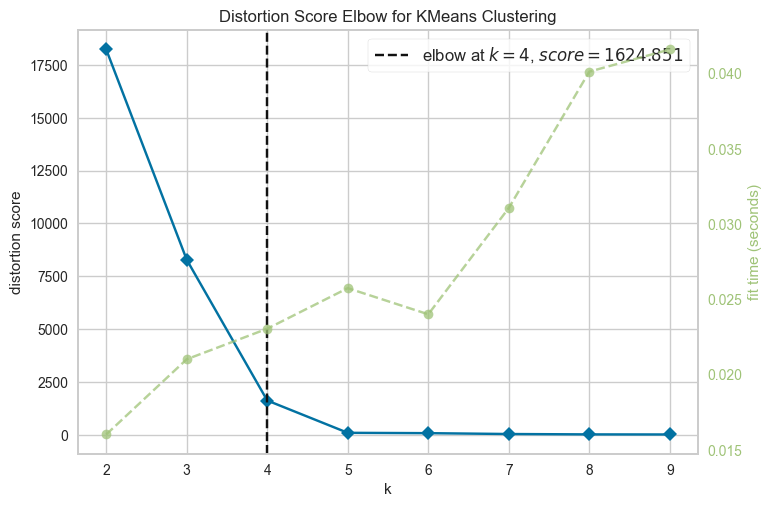

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [248]:
kmeans = KMeans(init='k-means++', random_state=0, n_init='auto')

visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(rfm[["RecencyScore", "FrequencyScore", "MonetaryScore"]])
visualizer.show()

In [249]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(rfm_no_outliers[["RecencyScore", "FrequencyScore", "MonetaryScore"]], n_clusters)   
#     plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

In [250]:
n_clusters=4

In [251]:
# Remove duplicate rows
# rfm_no_outliers = rfm_no_outliers.drop_duplicates()

# Re-run the clustering algorithm
# Replace 'your_clustering_algorithm' and 'n_clusters' with your specific algorithm and number of clusters
km = KMeans(n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm[["RecencyScore", "FrequencyScore", "MonetaryScore"]])
print(km.inertia_)

1624.850730250782


In [252]:
np.unique(clusters_predict)

array([0, 1, 2, 3])

In [253]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print("Davies Bouldin Score: ", davies_bouldin_score(rfm[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print("Calinski Score: ", calinski_harabasz_score(rfm[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))

"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print("Silhouette Score: ", silhouette_score(rfm[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))


Davies Bouldin Score:  0.09987238671060819
Calinski Score:  1149884.0271609614


Silhouette Score:  0.9623803300939211


In [218]:
# def label_country(df):
#     # assign a label to each country
#     country_label = OrdinalEncoder()
#     country_label.fit(df[['Country']])
#     df['CountryLabel'] = country_label.transform(df[['Country']])
#     return df

# rfm_and_country_df = label_country(rfm_and_country_df)
# rfm_and_country_df

In [219]:
rfm_and_country_df.iloc[:, 1:5]

Recency  RecencyScore      RecencyScoreText  Frequency
0          789             1  a very long time ago          1
1          467             3        no so recently          4
2            2             5         very recently        261
3          789             1  a very long time ago          1
4          501             2         some time ago          4
...        ...           ...                   ...        ...
62284        4             5         very recently          3
62285        3             5         very recently          1
62286        2             5         very recently          3
62287        2             5         very recently          2
62288        2             5         very recently          1

[62289 rows x 4 columns]

In [220]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df, 
                        x=columns[0], 
                        y=columns[1], 
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


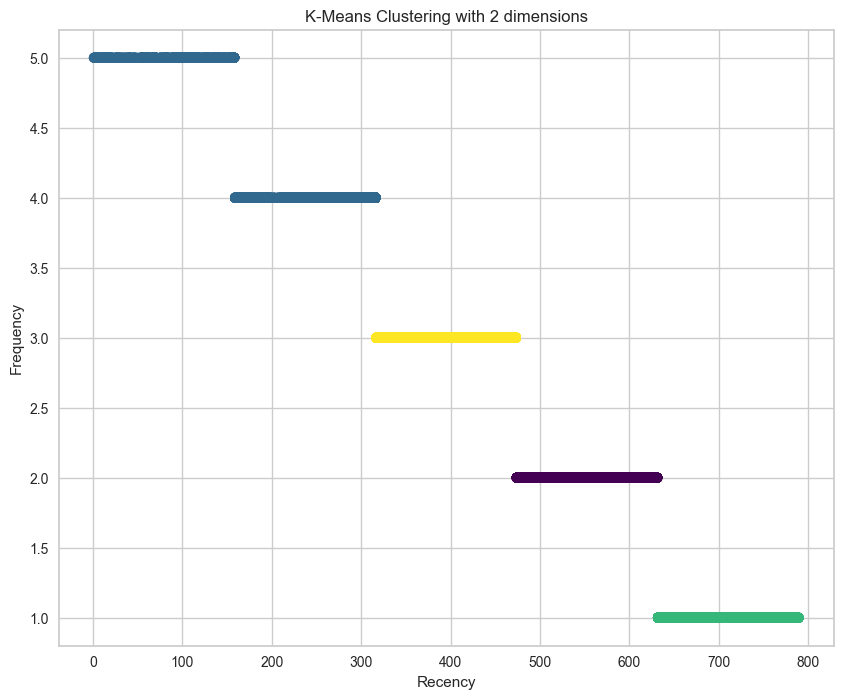

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(rfm_and_country_df.iloc[:, 1], rfm_and_country_df.iloc[:, 2], c=clusters_predict, cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('K-Means Clustering with 2 dimensions')
plt.show()

In [222]:
rfm_no_outliers.iloc[:, 1:]

RecencyScore  FrequencyScore  MonetaryScore
0                 1               1              1
1                 3               1              1
3                 1               1              1
4                 2               1              1
5                 1               1              1
...             ...             ...            ...
61332             4               1              1
61333             4               1              1
61334             4               1              1
61339             4               1              1
61340             4               1              1

[60612 rows x 3 columns]

In [223]:
rfm_and_country_df.iloc[:, 1:4]

Recency  RecencyScore      RecencyScoreText
0          789             1  a very long time ago
1          467             3        no so recently
2            2             5         very recently
3          789             1  a very long time ago
4          501             2         some time ago
...        ...           ...                   ...
62284        4             5         very recently
62285        3             5         very recently
62286        2             5         very recently
62287        2             5         very recently
62288        2             5         very recently

[62289 rows x 3 columns]

In [224]:
pca_3d_object, df_pca_3d = get_pca_3d(rfm.iloc[:, 1:], clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.019        33.96%                     33.96%
1              1.000        33.33%                     67.29%
2              0.981        32.71%                    100.00%


In [227]:
# number of points in each cluster
print(df_pca_3d["cluster"].value_counts())

# calculate the total number of points
total_points = df_pca_3d.shape[0]
print(f"Total points: {total_points}")

cluster
1    20622
2    14963
3    14002
0    12702
Name: count, dtype: int64
Total points: 62289


In [ ]:
# append the cluster labels to the original dataframe
rfm_and_country_df['cluster'] = clusters_predict
rfm_and_country_df.iloc[:, 1:]

RecencyScore  FrequencyScore  MonetaryScore  CountryLabel  cluster
0              1.0             1.0            1.0          34.0        2
2              2.0             3.0            4.0          12.0        1
3              4.0             4.0            4.0          17.0        1
4              1.0             2.0            2.0          23.0        4
5              3.0             4.0            4.0          23.0        4
...            ...             ...            ...           ...      ...
4366           2.0             1.0            1.0          34.0        2
4367           1.0             1.0            1.0          34.0        2
4368           1.0             1.0            1.0          34.0        2
4369           5.0             1.0            1.0          34.0        2
4371           3.0             4.0            4.0          34.0        0

[4048 rows x 5 columns]

In [ ]:
# analyze the clusters' characteristics
copy = rfm_and_country_df.iloc[:, 1:].groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

cluster  RecencyScore  FrequencyScore  MonetaryScore  CountryLabel  \
0        0      3.691589        3.847169       3.813634          1819   
1        1      2.976415        2.962264       3.231132           212   
2        2      2.049494        1.810005       1.821181          1879   
3        3      2.500000        2.935484       3.387097            62   
4        4      2.921053        2.907895       3.184211            76   

    TotalRFM  
0  11.352391  
1   9.169811  
2   5.680681  
3   8.822581  
4   9.013158

In [ ]:
# plot the cluster characteristics
fig = go.Figure()
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["RecencyScore"],
    name='RecencyScore',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["FrequencyScore"],
    name='FrequencyScore',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["MonetaryScore"],
    name='MonetaryScore',
    marker_color='lightblue'
))


fig.update_layout(
    title='Cluster Characteristics',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Value',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0.85,
        y=0.95,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1 
)
fig.show()

In [ ]:
rfm_scaled_no_outliers

Unnamed: 0  CustomerID  Recency  Frequency  MonetaryValue  \
0              0     12346.0      326          2           0.00   
2              2     12348.0       75         31        1797.24   
3              3     12349.0       19         73        1757.55   
4              4     12350.0      310         17         334.40   
5              5     12352.0       36         95        1545.41   
...          ...         ...      ...        ...            ...   
4366        4366     18278.0       74          9         173.90   
4367        4367     18280.0      278         10         180.60   
4368        4368     18281.0      181          7          80.82   
4369        4369     18282.0        8         13         176.60   
4371        4371     18287.0       43         70        1837.28   

             Country  RecencyScore  FrequencyScore  MonetaryScore  \
0     United Kingdom           1.0             1.0            1.0   
2            Finland           2.0             3.0            4.0   
3              Italy           4.0             4.0            4.0   
4             Norway           1.0             2.0            2.0   
5             Norway           3.0             4.0            4.0   
...              ...           ...             ...            ...   
4366  United Kingdom           2.0             1.0            1.0   
4367  United Kingdom           1.0             1.0            1.0   
4368  United Kingdom           1.0             1.0            1.0   
4369  United Kingdom           5.0             1.0            1.0   
4371  United Kingdom           3.0             4.0            4.0   

          RecencyScoreText   FrequencyScoreText         MonetaryScoreText  
0     a very long time ago     extremely rarely  only a very little money  
2            some time ago  somewhat frequently                some money  
3                 recently           frequently                some money  
4     a very long time ago               rarely            a little money  
5           no so recently           frequently                some money  
...                    ...                  ...                       ...  
4366         some time ago     extremely rarely  only a very little money  
4367  a very long time ago     extremely rarely  only a very little money  
4368  a very long time ago     extremely rarely  only a very little money  
4369         very recently     extremely rarely  only a very little money  
4371        no so recently           frequently                some money  

[4048 rows x 12 columns]

In [ ]:
# merge the original data with the clusters
rfm_scaled_no_outliers['cluster'] = clusters_predict

In [ ]:
# analyze the clusters' characteristics
copy = rfm_scaled_no_outliers.groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

KeyError: "Column(s) ['CountryLabel'] do not exist"

In [ ]:
# plot the clusters in 3d using scikit-learn
from sklearn.calibration import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rfm_scaled_no_outliers.iloc[:, 1:5], clusters_predict)

rfm_scaled_no_outliers['cluster'] = clusters_predict
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category')
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.rename_categories(['cluster_1', 'cluster_2', 'cluster_3'])

# convert categorical variable to numerical
# le = LabelEncoder()
# rfm_scaled_no_outliers['cluster'] = le.fit_transform(rfm_scaled_no_outliers['cluster'])
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category') # convert back to category type
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.codes

# plot it
fig = px.scatter_3d(rfm_scaled_no_outliers, 
                        x='RecencyScore', 
                        y='FrequencyScore', 
                        z='MonetaryScore',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title="title").update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": 0.8,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": 0.1,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
fig.show()

In [ ]:
rfm_scaled_no_outliers


CustomerID.1  RecencyScore  FrequencyScore  MonetaryScore  CountryLabel  \
2          12348.0           2.0             3.0            4.0          12.0   
3          12349.0           4.0             4.0            4.0          17.0   
4          12350.0           1.0             2.0            2.0          23.0   
5          12352.0           3.0             4.0            4.0          23.0   
7          12354.0           1.0             3.0            4.0          29.0   
...            ...           ...             ...            ...           ...   
4366       18278.0           2.0             1.0            1.0          34.0   
4367       18280.0           1.0             1.0            1.0          34.0   
4368       18281.0           1.0             1.0            1.0          34.0   
4369       18282.0           5.0             1.0            1.0          34.0   
4371       18287.0           3.0             4.0            4.0          34.0   

      cluster  
2           1  
3           1  
4           2  
5           1  
7           2  
...       ...  
4366        2  
4367        2  
4368        2  
4369        0  
4371        1  

[3934 rows x 6 columns]

In [ ]:
rfm_scaled_no_outliers.iloc[:, 1:5]

RecencyScore  FrequencyScore  MonetaryScore  CountryLabel
2              2.0             3.0            4.0          12.0
3              4.0             4.0            4.0          17.0
4              1.0             2.0            2.0          23.0
5              3.0             4.0            4.0          23.0
7              1.0             3.0            4.0          29.0
...            ...             ...            ...           ...
4366           2.0             1.0            1.0          34.0
4367           1.0             1.0            1.0          34.0
4368           1.0             1.0            1.0          34.0
4369           5.0             1.0            1.0          34.0
4371           3.0             4.0            4.0          34.0

[3934 rows x 4 columns]

In [ ]:
# analyze the clusters' characteristics
copy = rfm_scaled_no_outliers.groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

cluster  RecencyScore  FrequencyScore  MonetaryScore  CountryLabel  \
0        0      3.745794        2.201869       2.167290          1070   
1        1      3.652847        4.253094       4.246906          1616   
2        2      1.457532        1.978365       2.056090          1248   

    TotalRFM  
0   8.114953  
1  12.152847  
2   5.491987

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9642
[LightGBM] [Info] Number of data points in the train set: 88798, number of used features: 4
[LightGBM] [Info] Start training from score -1.407670
[LightGBM] [Info] Start training from score -0.993865
[LightGBM] [Info] Start training from score -0.954138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

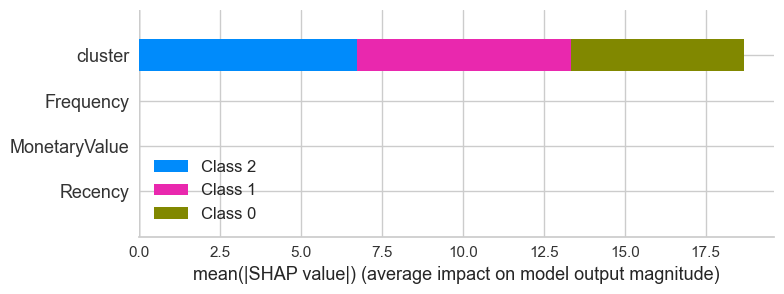

In [ ]:
from cv2 import exp
import lightgbm as lgb
from numpy import shape
import shap

clf_km = lgb.LGBMClassifier()

for col in rfm_scaled_no_outliers.columns[1:]:
    rfm_scaled_no_outliers[col] = rfm_scaled_no_outliers[col].astype('category')
    
clf_km.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

explainer = shap.TreeExplainer(clf_km)
shape_values = explainer.shap_values(rfm_scaled_no_outliers.iloc[:, 1:])
shap.summary_plot(shape_values, rfm_scaled_no_outliers.iloc[:, 1:], plot_type="bar")